In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

In [224]:
pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', 120)

# Load & merge

### 1. Prepping

In [225]:
df_bigtable = pd.read_csv('data/ailes_avion.csv', usecols=['Name', 'Family', 'Thickness(%)', 'x-Location_of_Max_Thk(%)', 'Camber(%)', 'Cl_Max'])
df_index = pd.read_csv('data/index_matchmaking.csv', usecols=['Name_big', 'Name_dat'])
df_coord = pd.read_csv('data/df_coordinates.csv')

In [226]:
df_coord

,name,new_x_coord,new_y_coord,0.0,0.02040816326530612,0.04081632653061224,0.061224489795918366,0.08163265306122448,0.1020408163265306,0.12244897959183673,0.14285714285714285,0.16326530612244897,0.18367346938775508,0.2040816326530612,0.22448979591836732,0.24489795918367346,0.26530612244897955,0.2857142857142857,0.3061224489795918,0.32653061224489793,0.3469387755102041,0.36734693877551017,0.3877551020408163,0.4081632653061224,0.42857142857142855,0.44897959183673464,0.4693877551020408,0.4897959183673469,0.5102040816326531,0.5306122448979591,0.5510204081632653,0.5714285714285714,0.5918367346938775,0.6122448979591836,0.6326530612244897,0.6530612244897959,0.673469387755102,0.6938775510204082,0.7142857142857142,0.7346938775510203,0.7551020408163265,0.7755102040816326,0.7959183673469387,0.8163265306122448,0.836734693877551,0.8571428571428571,0.8775510204081632,0.8979591836734693,0.9183673469387754,0.9387755102040816,0.9591836734693877,0.9795918367346939,1.0,0.0.1,0.02040816326530612.1,0.04081632653061224.1,0.061224489795918366.1,0.08163265306122448.1,0.1020408163265306.1,0.12244897959183673.1,0.14285714285714285.1,0.16326530612244897.1,0.18367346938775508.1,0.2040816326530612.1,0.22448979591836732.1,0.24489795918367346.1,0.26530612244897955.1,0.2857142857142857.1,0.3061224489795918.1,0.32653061224489793.1,0.3469387755102041.1,0.36734693877551017.1,0.3877551020408163.1,0.4081632653061224.1,0.42857142857142855.1,0.44897959183673464.1,0.4693877551020408.1,0.4897959183673469.1,0.5102040816326531.1,0.5306122448979591.1,0.5510204081632653.1,0.5714285714285714.1,0.5918367346938775.1,0.6122448979591836.1,0.6326530612244897.1,0.6530612244897959.1,0.673469387755102.1,0.6938775510204082.1,0.7142857142857142.1,0.7346938775510203.1,0.7551020408163265.1,0.7755102040816326.1,0.7959183673469387.1,0.8163265306122448.1,0.836734693877551.1,0.8571428571428571.1,0.8775510204081632.1,0.8979591836734693.1,0.9183673469387754.1,0.9387755102040816.1,0.9591836734693877.1,0.9795918367346939.1,1.0.1
0,a18.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ nan -0.01334918 -0.01661122 -0.017834...,NaN,-0.013349,-0.016611,-0.017834,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.01865,NaN,0.017937,0.025949,0.032359,0.038768,0.043576,0.046781,0.049986,0.051588,0.054793,0.056395,0.059600,0.061203,0.062805,0.062805,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.062805,0.062805,0.061203,0.059600,0.057998,0.056395,0.054793,0.053190,0.051588,0.048383,0.046781,0.043576,0.041973,0.038768,0.035563,0.033961,0.030756,0.027551,0.024346,0.019539,0.016334,0.013129,0.009924,0.005117,0.000310,-0.002895,-0.007703,-0.01251
1,a18sm.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ nan -0.01281714 -0.01568143 -0.016827...,NaN,-0.012817,-0.015681,-0.016827,-0.016827,-0.016827,-0.016254,-0.016254,-0.015681,-0.015681,-0.015109,-0.014536,-0.014536,-0.013963,-0.013963,-0.013390,-0.013390,-0.012817,-0.012817,-0.012244,-0.011671,-0.011671,-0.011099,-0.011099,-0.010526,-0.010526,-0.009953,-0.009953,-0.009380,-0.009380,-0.008807,-0.008234,-0.008234,-0.007661,-0.007661,-0.007089,-0.007089,-0.006516,-0.006516,-0.005943,-0.005370,-0.005370,-0.004797,-0.004797,-0.004224,-0.004224,-0.003651,-0.003651,-0.003079,NaN,0.0,0.017527,0.027752,0.033594,0.039437,0.043818,0.048200,0.051121,0.055503,0.056964,0.059885,0.062806,0.064267,0.065728,0.067188,0.068649,0.070109,0.070109,0.070109,0.070109,0.070109,0.070109,0.070109,0.068649,0.068649,0.067188,0.065728,0.065728,0.064267,0.062806,0.059885,0.058424,0.056964,0.054043,0.052582,0.049661,0.048200,0.045279,0.042358,0.039437,0.036515,0.033594,0.030673,

In [227]:
df_index.rename(columns={"Name_big": "Name"}, inplace=True)
df_bigtable_indexed = pd.merge(df_bigtable, df_index, on="Name", how="inner")

df_coord.rename(columns={"name": "Name_dat"}, inplace=True)
df_big_coord = pd.merge(df_bigtable_indexed, df_coord, on="Name_dat", how="inner")

In [228]:
print(df_bigtable.shape)
print(df_bigtable_indexed.shape)
print(df_index.shape)
print(df_coord.shape)

(6324, 6)
(6307, 7)
(6303, 2)
(6303, 103)


In [229]:
df_big_coord

,Name,Family,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max,Name_dat,new_x_coord,new_y_coord,0.0,0.02040816326530612,0.04081632653061224,0.061224489795918366,0.08163265306122448,0.1020408163265306,0.12244897959183673,0.14285714285714285,0.16326530612244897,0.18367346938775508,0.2040816326530612,0.22448979591836732,0.24489795918367346,0.26530612244897955,0.2857142857142857,0.3061224489795918,0.32653061224489793,0.3469387755102041,0.36734693877551017,0.3877551020408163,0.4081632653061224,0.42857142857142855,0.44897959183673464,0.4693877551020408,0.4897959183673469,0.5102040816326531,0.5306122448979591,0.5510204081632653,0.5714285714285714,0.5918367346938775,0.6122448979591836,0.6326530612244897,0.6530612244897959,0.673469387755102,0.6938775510204082,0.7142857142857142,0.7346938775510203,0.7551020408163265,0.7755102040816326,0.7959183673469387,0.8163265306122448,0.836734693877551,0.8571428571428571,0.8775510204081632,0.8979591836734693,0.9183673469387754,0.9387755102040816,0.9591836734693877,0.9795918367346939,1.0,0.0.1,0.02040816326530612.1,0.04081632653061224.1,0.061224489795918366.1,0.08163265306122448.1,0.1020408163265306.1,0.12244897959183673.1,0.14285714285714285.1,0.16326530612244897.1,0.18367346938775508.1,0.2040816326530612.1,0.22448979591836732.1,0.24489795918367346.1,0.26530612244897955.1,0.2857142857142857.1,0.3061224489795918.1,0.32653061224489793.1,0.3469387755102041.1,0.36734693877551017.1,0.3877551020408163.1,0.4081632653061224.1,0.42857142857142855.1,0.44897959183673464.1,0.4693877551020408.1,0.4897959183673469.1,0.5102040816326531.1,0.5306122448979591.1,0.5510204081632653.1,0.5714285714285714.1,0.5918367346938775.1,0.6122448979591836.1,0.6326530612244897.1,0.6530612244897959.1,0.673469387755102.1,0.6938775510204082.1,0.7142857142857142.1,0.7346938775510203.1,0.7551020408163265.1,0.7755102040816326.1,0.7959183673469387.1,0.8163265306122448.1,0.836734693877551.1,0.8571428571428571.1,0.8775510204081632.1,0.8979591836734693.1,0.9183673469387754.1,0.9387755102040816.1,0.9591836734693877.1,0.9795918367346939.1,1.0.1
0,63A108 MOD C,NASA,7.7,30.1,0.6,1.02,a63a108c.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ 0. -0.01572449 -0.01982653 -0.022561...,0.000000,-0.015724,-0.019827,-0.022561,-0.024612,-0.026663,-0.028031,-0.029398,-0.030082,-0.030765,-0.031449,-0.032133,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032133,-0.031449,-0.030765,-0.030082,-0.029398,-0.028714,-0.028031,-0.026663,-0.025980,-0.024612,-0.023245,-0.022561,-0.021194,-0.019827,-0.018459,-0.017092,-0.015724,-0.015041,-0.013673,-0.012306,-0.010939,-0.009571,-0.008204,-0.007520,-0.006153,-0.004786,-0.003418,-0.002051,-0.000684,0.00000,0.0,0.021478,0.027742,0.032216,0.034901,0.036691,0.038481,0.039376,0.041165,0.041165,0.042060,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042060,0.042060,0.041165,0.040270,0.040270,0.039376,0.038481,0.037586,0.036691,0.035796,0.034006,0.033111,0.032216,0.030427,0.028637,0.027742,0.025952,0.024162,0.023267,0.021478,0.019688,0.018793,0.017003,0.015213,0.014318,0.012529,0.010739,0.009844,0.008054,NaN
1,A18,Uncategorized,7.3,30.1,3.2,1.40,a18.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ nan -0.01334918 -0.01661122 -0.017834...,NaN,-0.013349,-0.016611,-0.017834,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.01865,NaN,0.017937,0.025949,0.032359,0.038768,0.043576,0.046781,0.049986,0.051588,0.054793,0.056395,0.059600,0.061203,0.062805,0.062805,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.062805,0.062805,0.061203,0.059600,0.0579

### 2. Exceptions to treat

In [230]:
df_big_coord.Name.value_counts().sort_values(ascending=False)

Name
FX 66-17AII-182       4
BOEING 737 MIDSPAN    4
MH 102 16.99%         1
A6016-S               1
A6020-S               1
                     ..
ZONE-46               1
YS-915                1
USA-35B               1
USA 98                1
ZONE-52               1
Name: count, Length: 6301, dtype: int64

In [231]:
df_big_coord[df_big_coord['Name'] == 'FX 66-17AII-182']

,Name,Family,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max,Name_dat,new_x_coord,new_y_coord,0.0,0.02040816326530612,0.04081632653061224,0.061224489795918366,0.08163265306122448,0.1020408163265306,0.12244897959183673,0.14285714285714285,0.16326530612244897,0.18367346938775508,0.2040816326530612,0.22448979591836732,0.24489795918367346,0.26530612244897955,0.2857142857142857,0.3061224489795918,0.32653061224489793,0.3469387755102041,0.36734693877551017,0.3877551020408163,0.4081632653061224,0.42857142857142855,0.44897959183673464,0.4693877551020408,0.4897959183673469,0.5102040816326531,0.5306122448979591,0.5510204081632653,0.5714285714285714,0.5918367346938775,0.6122448979591836,0.6326530612244897,0.6530612244897959,0.673469387755102,0.6938775510204082,0.7142857142857142,0.7346938775510203,0.7551020408163265,0.7755102040816326,0.7959183673469387,0.8163265306122448,0.836734693877551,0.8571428571428571,0.8775510204081632,0.8979591836734693,0.9183673469387754,0.9387755102040816,0.9591836734693877,0.9795918367346939,1.0,0.0.1,0.02040816326530612.1,0.04081632653061224.1,0.061224489795918366.1,0.08163265306122448.1,0.1020408163265306.1,0.12244897959183673.1,0.14285714285714285.1,0.16326530612244897.1,0.18367346938775508.1,0.2040816326530612.1,0.22448979591836732.1,0.24489795918367346.1,0.26530612244897955.1,0.2857142857142857.1,0.3061224489795918.1,0.32653061224489793.1,0.3469387755102041.1,0.36734693877551017.1,0.3877551020408163.1,0.4081632653061224.1,0.42857142857142855.1,0.44897959183673464.1,0.4693877551020408.1,0.4897959183673469.1,0.5102040816326531.1,0.5306122448979591.1,0.5510204081632653.1,0.5714285714285714.1,0.5918367346938775.1,0.6122448979591836.1,0.6326530612244897.1,0.6530612244897959.1,0.673469387755102.1,0.6938775510204082.1,0.7142857142857142.1,0.7346938775510203.1,0.7551020408163265.1,0.7755102040816326.1,0.7959183673469387.1,0.8163265306122448.1,0.836734693877551.1,0.8571428571428571.1,0.8775510204081632.1,0.8979591836734693.1,0.9183673469387754.1,0.9387755102040816.1,0.9591836734693877.1,0.9795918367346939.1,1.0.1
592,FX 66-17AII-182,Wortmann,18.8,35.8,3.7,1.59,fx6617ai.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ 0. -0.01888 -0.02714 -0.03186 ...,0.0,-0.018880,-0.027140,-0.031860,-0.036580,-0.041300,-0.043660,-0.047200,-0.049560,-0.050740,-0.05310,-0.054280,-0.055460,-0.056640,-0.056640,-0.056640,-0.056640,-0.056640,-0.056640,-0.055460,-0.054280,-0.053100,-0.051920,-0.049560,-0.048380,-0.046020,-0.044840,-0.042480,-0.040120,-0.038940,-0.036580,-0.034220,-0.033040,-0.03068,-0.029500,-0.027140,-0.02478,-0.023600,-0.021240,-0.018880,-0.017700,-0.015340,-0.012980,-0.011800,-0.009440,-0.008260,-0.00590,-0.003540,-0.002360,NaN,0.0,0.026665,0.039998,0.053331,0.063997,0.074663,0.082662,0.090662,0.098662,0.103995,0.109328,0.114661,0.117327,0.122660,0.125327,0.127993,0.127993,0.127993,0.127993,0.127993,0.127993,0.125327,0.122660,0.119994,0.114661,0.111994,0.106661,0.103995,0.098662,0.093329,0.090662,0.085329,0.079996,0.074663,0.071996,0.066663,0.061330,0.055997,0.050664,0.047998,0.042664,0.037331,0.031998,0.029332,0.023999,0.018666,0.013333,0.008000,0.005333,NaN
593,FX 66-17AII-182,Wortmann,18.2,35.8,3.8,1.59,fx6617ai.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ 0. -0.01888 -0.02714 -0.03186 ...,0.0,-0.018880,-0.027140,-0.031860,-0.036580,-0.041300,-0.043660,-0.047200,-0.049560,-0.050740,-0.05310,-0.054280,-0.055460,-0.056640,-0.056640,-0.056640,-0.056640,-0.056640,-0.056640,-0.055460,-0.054280,-0.053100,-0.051920,-0.049560,-0.048380,-0.046020,-0.044840,-0.042480,-0.040120,-0.038940,-0.036580,-0.034220,-0.033040,-0.03068,-0.029500,-0.027140,-0.02478,-0.023600,-0.021240,-0.018880,-0.017700,-0.015340,-0.012980,-0.011800,-0.009440,-0.008260,-0.00590,-0.003540,-0.002360,NaN,0.0,0.026665,0.039998,0.053331,0.063997,0.074663,0.082662,0.090662,0.098662,0.103995,0.109328,0.114661,0.117327,0.122660,0.125327,0.127993,0.127993,0.127993,0.127993,0.127993,0.127993,0.125327,0.122660,0.119994,0.114661,0.111994,0.106661,0.10399

In [232]:
df_big_coord[df_big_coord['Name'] == 'BOEING 737 MIDSPAN']

,Name,Family,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max,Name_dat,new_x_coord,new_y_coord,0.0,0.02040816326530612,0.04081632653061224,0.061224489795918366,0.08163265306122448,0.1020408163265306,0.12244897959183673,0.14285714285714285,0.16326530612244897,0.18367346938775508,0.2040816326530612,0.22448979591836732,0.24489795918367346,0.26530612244897955,0.2857142857142857,0.3061224489795918,0.32653061224489793,0.3469387755102041,0.36734693877551017,0.3877551020408163,0.4081632653061224,0.42857142857142855,0.44897959183673464,0.4693877551020408,0.4897959183673469,0.5102040816326531,0.5306122448979591,0.5510204081632653,0.5714285714285714,0.5918367346938775,0.6122448979591836,0.6326530612244897,0.6530612244897959,0.673469387755102,0.6938775510204082,0.7142857142857142,0.7346938775510203,0.7551020408163265,0.7755102040816326,0.7959183673469387,0.8163265306122448,0.836734693877551,0.8571428571428571,0.8775510204081632,0.8979591836734693,0.9183673469387754,0.9387755102040816,0.9591836734693877,0.9795918367346939,1.0,0.0.1,0.02040816326530612.1,0.04081632653061224.1,0.061224489795918366.1,0.08163265306122448.1,0.1020408163265306.1,0.12244897959183673.1,0.14285714285714285.1,0.16326530612244897.1,0.18367346938775508.1,0.2040816326530612.1,0.22448979591836732.1,0.24489795918367346.1,0.26530612244897955.1,0.2857142857142857.1,0.3061224489795918.1,0.32653061224489793.1,0.3469387755102041.1,0.36734693877551017.1,0.3877551020408163.1,0.4081632653061224.1,0.42857142857142855.1,0.44897959183673464.1,0.4693877551020408.1,0.4897959183673469.1,0.5102040816326531.1,0.5306122448979591.1,0.5510204081632653.1,0.5714285714285714.1,0.5918367346938775.1,0.6122448979591836.1,0.6326530612244897.1,0.6530612244897959.1,0.673469387755102.1,0.6938775510204082.1,0.7142857142857142.1,0.7346938775510203.1,0.7551020408163265.1,0.7755102040816326.1,0.7959183673469387.1,0.8163265306122448.1,0.836734693877551.1,0.8571428571428571.1,0.8775510204081632.1,0.8979591836734693.1,0.9183673469387754.1,0.9387755102040816.1,0.9591836734693877.1,0.9795918367346939.1,1.0.1
154,BOEING 737 MIDSPAN,Boeing,10.0,37.7,1.4,1.07,b737c.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ 0. -0.00994898 -0.0122449 -0.014540...,0.0,-0.009949,-0.012245,-0.014541,-0.016837,-0.019133,-0.021429,-0.022959,-0.02449,-0.026786,-0.028316,-0.029847,-0.031378,-0.032143,-0.033673,-0.034439,-0.035204,-0.035969,-0.036735,-0.036735,-0.036735,-0.036735,-0.035969,-0.035969,-0.035204,-0.033673,-0.032908,-0.032143,-0.030612,-0.029847,-0.028316,-0.027551,-0.02602,-0.025255,-0.02449,-0.022959,-0.022194,-0.020663,-0.019133,-0.017602,-0.016071,-0.013776,-0.012245,-0.010714,-0.009184,-0.006888,-0.005357,-0.003827,-0.001531,NaN,0.0,0.019255,0.028241,0.034659,0.039794,0.043645,0.047496,0.050063,0.052631,0.055198,0.056482,0.057765,0.059049,0.060333,0.061616,0.061616,0.061616,0.061616,0.061616,0.061616,0.061616,0.060333,0.060333,0.060333,0.059049,0.056482,0.055198,0.052631,0.050063,0.048780,0.046212,0.043645,0.042361,0.039794,0.037227,0.034659,0.033376,0.030808,0.028241,0.025673,0.024390,0.021822,0.019255,0.016688,0.014120,0.011553,0.008986,0.005135,0.002567,NaN
155,BOEING 737 MIDSPAN,Boeing,12.6,28.2,0.7,1.49,b737c.DAT,[0. 0.02040816 0.04081633 0.06122449 0...,[ 0. -0.00994898 -0.0122449 -0.014540...,0.0,-0.009949,-0.012245,-0.014541,-0.016837,-0.019133,-0.021429,-0.022959,-0.02449,-0.026786,-0.028316,-0.029847,-0.031378,-0.032143,-0.033673,-0.034439,-0.035204,-0.035969,-0.036735,-0.036735,-0.036735,-0.036735,-0.035969,-0.035969,-0.035204,-0.033673,-0.032908,-0.032143,-0.030612,-0.029847,-0.028316,-0.027551,-0.02602,-0.025255,-0.02449,-0.022959,-0.022194,-0.020663,-0.019133,-0.017602,-0.016071,-0.013776,-0.012245,-0.010714,-0.009184,-0.006888,-0.005357,-0.003827,-0.001531,NaN,0.0,0.019255,0.028241,0.034659,0.039794,0.043645,0.047496,0.050063,0.052631,0.055198,0.056482,0.057765,0.059049,0.060333,0.061616,0.061616,0.061616,0.061616,0.061616,0.061616,0.061616,0.060333,0.060333,0.060333,0.059049,0.056482,0.055198

# Data Pre-processing

In [233]:
print(df_big_coord.shape)
print(df_big_coord.dtypes[df_big_coord.dtypes == object])

(6307, 109)
Name           object
Family         object
Camber(%)      object
Cl_Max         object
Name_dat       object
new_x_coord    object
new_y_coord    object
dtype: object


In [234]:
# Dtop the unnecessary columns
df = df_big_coord.drop(columns=['Name', 'Family', 'Name_dat', 'new_x_coord', 'new_y_coord'], axis=0)

# Replace unknown values to be able to convert the object column to float
df.replace({'-': None}, inplace=True)

# Convert the necessary colums to float
df['Camber(%)'] = df['Camber(%)'].astype(float)

In [235]:
# Number of unknown values per column
print(df.isna().sum()[df.isna().sum() > 0])
# Comparison
ratio_na = (df.isna().sum().sum()/df.size)*100
print(f'The dataset contains {df.size} with only {df.isna().sum().sum()} missing values. (ratio {round(ratio_na,2)}%)')
# Imputation
df.loc[df['0.0'].isna(), '0.0'] = 0
df.loc[df['0.0.1'].isna(), '0.0.1'] = 0
df.loc[df['1.0'].isna(), '1.0'] = 0
df.loc[df['1.0.1'].isna(), '1.0.1'] = 0
# Delete the rows with missing value
df = df.dropna()

Camber(%)       6
Cl_Max          9
0.0          1685
1.0          4843
0.0.1        3997
1.0.1        4857
dtype: int64
The dataset contains 655928 with only 15397 missing values. (ratio 2.35%)


In [236]:
df

,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max,0.0,0.02040816326530612,0.04081632653061224,0.061224489795918366,0.08163265306122448,0.1020408163265306,0.12244897959183673,0.14285714285714285,0.16326530612244897,0.18367346938775508,0.2040816326530612,0.22448979591836732,0.24489795918367346,0.26530612244897955,0.2857142857142857,0.3061224489795918,0.32653061224489793,0.3469387755102041,0.36734693877551017,0.3877551020408163,0.4081632653061224,0.42857142857142855,0.44897959183673464,0.4693877551020408,0.4897959183673469,0.5102040816326531,0.5306122448979591,0.5510204081632653,0.5714285714285714,0.5918367346938775,0.6122448979591836,0.6326530612244897,0.6530612244897959,0.673469387755102,0.6938775510204082,0.7142857142857142,0.7346938775510203,0.7551020408163265,0.7755102040816326,0.7959183673469387,0.8163265306122448,0.836734693877551,0.8571428571428571,0.8775510204081632,0.8979591836734693,0.9183673469387754,0.9387755102040816,0.9591836734693877,0.9795918367346939,1.0,0.0.1,0.02040816326530612.1,0.04081632653061224.1,0.061224489795918366.1,0.08163265306122448.1,0.1020408163265306.1,0.12244897959183673.1,0.14285714285714285.1,0.16326530612244897.1,0.18367346938775508.1,0.2040816326530612.1,0.22448979591836732.1,0.24489795918367346.1,0.26530612244897955.1,0.2857142857142857.1,0.3061224489795918.1,0.32653061224489793.1,0.3469387755102041.1,0.36734693877551017.1,0.3877551020408163.1,0.4081632653061224.1,0.42857142857142855.1,0.44897959183673464.1,0.4693877551020408.1,0.4897959183673469.1,0.5102040816326531.1,0.5306122448979591.1,0.5510204081632653.1,0.5714285714285714.1,0.5918367346938775.1,0.6122448979591836.1,0.6326530612244897.1,0.6530612244897959.1,0.673469387755102.1,0.6938775510204082.1,0.7142857142857142.1,0.7346938775510203.1,0.7551020408163265.1,0.7755102040816326.1,0.7959183673469387.1,0.8163265306122448.1,0.836734693877551.1,0.8571428571428571.1,0.8775510204081632.1,0.8979591836734693.1,0.9183673469387754.1,0.9387755102040816.1,0.9591836734693877.1,0.9795918367346939.1,1.0.1
0,7.7,30.1,0.6,1.02,0.000000,-0.015724,-0.019827,-0.022561,-0.024612,-0.026663,-0.028031,-0.029398,-0.030082,-0.030765,-0.031449,-0.032133,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032816,-0.032133,-0.031449,-0.030765,-0.030082,-0.029398,-0.028714,-0.028031,-0.026663,-0.025980,-0.024612,-0.023245,-0.022561,-0.021194,-0.019827,-0.018459,-0.017092,-0.015724,-0.015041,-0.013673,-0.012306,-0.010939,-0.009571,-0.008204,-0.007520,-0.006153,-0.004786,-0.003418,-0.002051,-0.000684,0.00000,0.0,0.021478,0.027742,0.032216,0.034901,0.036691,0.038481,0.039376,0.041165,0.041165,0.042060,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042955,0.042060,0.042060,0.041165,0.040270,0.040270,0.039376,0.038481,0.037586,0.036691,0.035796,0.034006,0.033111,0.032216,0.030427,0.028637,0.027742,0.025952,0.024162,0.023267,0.021478,0.019688,0.018793,0.017003,0.015213,0.014318,0.012529,0.010739,0.009844,0.008054,0.00000
1,7.3,30.1,3.2,1.40,0.000000,-0.013349,-0.016611,-0.017834,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.018650,-0.01865,0.0,0.017937,0.025949,0.032359,0.038768,0.043576,0.046781,0.049986,0.051588,0.054793,0.056395,0.059600,0.061203,0.062805,0.062805,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.064408,0.062805,0.062805,0.061203,0.059600,0.057998,0.056395,0.054793,0.053190,0.051588,0.048383,0.046781,0.043576,0.041973,0.038768,0.035563,0.033961,0.030756,0.027551,0.024346,0.019539,0.016334,0.013129,0.009924,0.005117,0.000310,-0.002895,-0.007703,-0.01251
2,7.3,26.5,3.8,1.31,0.000000,-0.012817,-0.015681,-

In [237]:
# Separate the features X from the target y and verify the shape
y = df[['Cl_Max']]
X = df.drop(columns=['Cl_Max'], axis=0)
print(y.shape)
print(X.shape)
# Splitting the dataset into training (80%) and testing (20%)
# Random_state is used to use the same randomization seed every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(6292, 1)
(6292, 103)


In [238]:
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(f"Shape des training targets {y_train.shape} \n")
print(f"Shape des testing targets {y_test.shape} \n")

Shape des training targets (5033, 1) 

Shape des testing targets (1259, 1) 



# Data Modelling

In [239]:
model_lg = LinearRegression()
model_lg.fit(X_train, y_train)
print(model_lg.score(X_test, y_test))
print("Coefficients: \n", model_lg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, model_lg.predict(X_test)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, model_lg.predict(X_test)))

0.9653204407283337
Coefficients: 
 [[-5.78624861e-03 -5.72281376e-03  3.68670965e-02  2.60957401e+01
  -1.42128577e+01  7.74643993e-01  1.96767775e+00 -9.88238738e-01
  -9.55286143e+00  9.51004221e+00  1.90454677e+00  8.98513647e+00
   4.81601443e+00 -5.02274302e+00 -5.63611927e+00  2.47739762e+00
   2.00609608e+00 -9.99823708e+00 -1.17037731e+01  1.29058677e+01
   6.24253213e+00  3.25848157e+00 -1.03778642e+01 -8.66291238e+00
   5.32306447e+00  4.33102088e+00  5.57654669e+00 -3.73721935e+00
  -3.91044608e+00  2.94882947e+00  2.49455917e+00 -4.45589712e+00
   7.86424617e+00 -8.20317749e+00  4.09480115e+00 -2.00280860e+00
  -8.36187862e+00 -8.42849864e-01  5.02564465e+00  5.84564813e+00
   2.70677761e+00 -4.67691700e+00 -2.81687470e+00 -2.76309037e+00
   5.69571272e+00  3.47680387e+00  4.55798422e+00 -3.48536090e+00
   2.05330569e+00 -1.58864262e+00  7.65021442e-01 -1.06358297e-01
  -1.27803135e+00 -3.91742564e+10  9.05814208e+00  8.54906662e+00
   3.41362973e+00  2.59791570e+00  5.6222

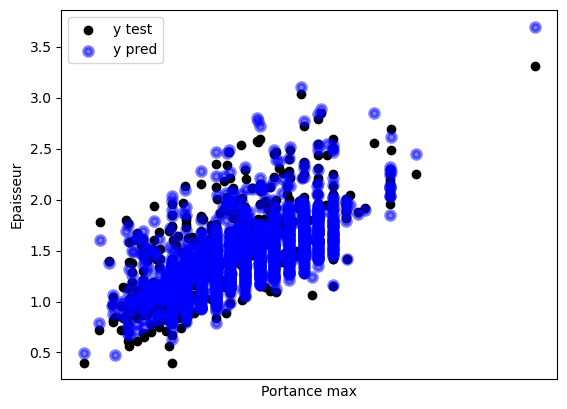

In [240]:
# Plot outputs
y_test = y_test.tolist()
plt.scatter(X_test.iloc[:,0], y_test, color="black", label='y test')
plt.scatter(X_test.iloc[:,0], model_lg.predict(X_test), color="blue", linewidth=3, alpha=0.5, label='y pred')
plt.legend()
plt.xticks(())
plt.xlabel('Portance max')
plt.ylabel('Epaisseur')
plt.show()